libraries

In [ ]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm
import numpy as np
from lazypredict.Supervised import LazyRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import ExtraTreesRegressor, HistGradientBoostingRegressor, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from IPython.display import display


Understanding the dataset 

In [13]:
csv_file = "/home/riya23235/DSG_PROJECT_FINAL/Enhancers_zscores_peakscores.csv"
df2 = pd.read_csv(csv_file, header=2) 
print(df2.columns)
print(df2.head())
print("\nShape of dataset Enhancers_zscores_peakscores  (rows, columns):", df2.shape)


Index(['chr1', '57276953', '57277003', '-0.199590345', 'Non Significant',
       'enh49776-Pancreas',
       'caagaaatttagcttcaaaatgcattttaaaagtttttcctttcttgctt', '0.7319676',
       '3.593328', '2.028041',
       ...
       '2.9181265', '6.7548473', '1.1118264', '1.900633', '4.4589091',
       '3.9173572', '2.8449344', '2.366074', '1.439042', '0.302854'],
      dtype='object', length=1007)
   chr1  57276953  57277003  -0.199590345  Non Significant  \
0  chr1  57276953  57277003     -0.199590  Non Significant   
1  chr1  57276992  57277042      0.241739  Non Significant   
2  chr1  57276992  57277042      0.241739  Non Significant   
3  chr1  57276992  57277042      0.241739  Non Significant   
4  chr1  57277008  57277058     -1.792090  Non Significant   

         enh49776-Pancreas caagaaatttagcttcaaaatgcattttaaaagtttttcctttcttgctt  \
0         enh49776-Stomach  caagaaatttagcttcaaaatgcattttaaaagtttttcctttctt...   
1  enh49776-LargeIntestine  ctttcttgctttcagccttgaaacacactttaaaactttcttt

In [15]:
csv_file = "/home/riya23235/DSG_PROJECT_FINAL/embeddings.csv"
df = pd.read_csv(csv_file, header=2) 
print(df.columns)
print(df.head())
print("\nShape of dataset embeddings.csv  (rows, columns):", df.shape)


Index(['chr1', '57276953', '57277003', '-0.199590345', 'Non Significant',
       'enh49776-Pancreas',
       'caagaaatttagcttcaaaatgcattttaaaagtttttcctttcttgctt', '0.7319676',
       '3.593328', '2.028041',
       ...
       '0.17910063', '0.44229597', '-0.30679908', '-0.66577977', '-0.20380639',
       '0.2193214', '-0.26943195', '0.018943446', '-0.34873846',
       '-0.50957644'],
      dtype='object', length=1775)
   chr1  57276953  57277003  -0.199590345  Non Significant  \
0  chr1  57276953  57277003     -0.199590  Non Significant   
1  chr1  57276992  57277042      0.241739  Non Significant   
2  chr1  57276992  57277042      0.241739  Non Significant   
3  chr1  57276992  57277042      0.241739  Non Significant   
4  chr1  57277008  57277058     -1.792090  Non Significant   

         enh49776-Pancreas caagaaatttagcttcaaaatgcattttaaaagtttttcctttcttgctt  \
0         enh49776-Stomach  caagaaatttagcttcaaaatgcattttaaaagtttttcctttctt...   
1  enh49776-LargeIntestine  ctttcttgctttcagc

Generating Embeddings

In [11]:
tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-base-cased-v1.1")
model = AutoModel.from_pretrained("dmis-lab/biobert-base-cased-v1.1")

model.eval()  # Set model to evaluation mode

# Check if CUDA is available and use it
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Load your dataframe (ensure 'sequence' column exists)
df = pd.read_csv("/home/riya23235/DSG_PROJECT_FINAL/Enhancers_zscores_peakscores.csv")  # Adjust as needed

def get_biobart_embedding(seq):
    inputs = tokenizer(seq, return_tensors="pt", truncation=True, padding=True, max_length=512)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    embedding = outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()
    return embedding

# Apply the function to all sequences
tqdm.pandas()
df['biobart_embedding'] = df['sequence'].progress_apply(get_biobart_embedding)

# Save as JSON (list format)
df.to_json("/home/riya23235/DSG_PROJECT_FINAL/embeddings.json", orient="records")

# Save as CSV — flatten embeddings
embedding_df = pd.DataFrame(df['biobart_embedding'].tolist())
final_df = pd.concat([df.drop(columns=['biobart_embedding']), embedding_df], axis=1)
final_df.to_csv("/home/riya23235/DSG_PROJECT_FINAL/embeddings.csv", index=False)


100%|██████████| 45483/45483 [04:19<00:00, 175.20it/s]


Z_Score analysis 

In [ ]:
# Load the CSV file
df = pd.read_csv('/home/riya23235/DSG_PROJECT_FINAL/embeddings.csv')

# Check min and max Z_score
min_z = df['Z_score'].min()
max_z = df['Z_score'].max()
print(f"Minimum Z_score: {min_z}")
print(f"Maximum Z_score: {max_z}")

# Classify significance
df['Significance'] = df['Z_score'].apply(lambda x: 'Highly Significant' if x >= 2.0 else 'Non Significant')

# Count the number of each class
significance_counts = df['Significance'].value_counts()

print("\nZ_score classification:")
print(significance_counts)


In [ ]:
df = pd.read_csv('/home/riya23235/DSG_PROJECT_FINAL/Enhancers_zscores_peakscores.csv')

print(df.shape)              
print(df.columns[:20])       
df.info()                    
df.describe().T  


plt.figure(figsize=(7, 5))
sns.histplot(df['Z_score'], bins=100, kde=True, color='skyblue')
plt.title('Distribution of Z_score')
plt.xlabel('Z_score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 2))
sns.boxplot(x=df['Z_score'], color='orange')
plt.title('Boxplot of Z_score')
plt.xlabel('Z_score')
plt.show()



Applying Lazy Predict Regressor 

In [1]:
# Load data
data = pd.read_csv("/home/riya23235/DSG_PROJECT_FINAL/embeddings.csv")

# Drop rows with any NaNs or infinities
data = data.replace([np.inf, -np.inf], np.nan).dropna()

# Ensure all columns are numeric
data = data.select_dtypes(include=[np.number])

# Define target and features
X = data.drop(columns=['Z_score'])
y = data['Z_score']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit LazyRegressor
reg = LazyRegressor(verbose=1)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

# View results
print(models)

# Optionally round for cleaner view
models_rounded = models_sorted.round(4)

# Display styled table
display(models_rounded.style.background_gradient(cmap="Blues"))


  2%|▏         | 1/42 [05:06<3:29:07, 306.03s/it]

{'Model': 'AdaBoostRegressor', 'R-Squared': -0.6875588871741523, 'Adjusted R-Squared': -1.0952819598329362, 'RMSE': 1.8251171782847144, 'Time taken': 306.033403635025}


  5%|▍         | 2/42 [17:59<6:27:18, 580.96s/it]

{'Model': 'BaggingRegressor', 'R-Squared': 0.9167005656336799, 'Adjusted R-Squared': 0.8965749856680251, 'RMSE': 0.4054920190167684, 'Time taken': 773.4114172458649}


  7%|▋         | 3/42 [18:13<3:29:23, 322.15s/it]

{'Model': 'BayesianRidge', 'R-Squared': 0.3995982339348887, 'Adjusted R-Squared': 0.25453802018451366, 'RMSE': 1.0886349301768452, 'Time taken': 14.15605878829956}


 10%|▉         | 4/42 [20:03<2:31:04, 238.53s/it]

{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.8536968604176022, 'Adjusted R-Squared': 0.8183492550311915, 'RMSE': 0.5373881772104102, 'Time taken': 110.33824801445007}


 12%|█▏        | 5/42 [20:05<1:34:23, 153.06s/it]

{'Model': 'DummyRegressor', 'R-Squared': -1.6260140147661417e-05, 'Adjusted R-Squared': -0.24162543028047834, 'RMSE': 1.4049627677704593, 'Time taken': 1.5060217380523682}


 14%|█▍        | 6/42 [20:07<1:01:00, 101.69s/it]

{'Model': 'ElasticNet', 'R-Squared': -1.6260140147661417e-05, 'Adjusted R-Squared': -0.24162543028047834, 'RMSE': 1.4049627677704593, 'Time taken': 1.971040964126587}


 17%|█▋        | 7/42 [25:16<1:38:53, 169.52s/it]

{'Model': 'ElasticNetCV', 'R-Squared': 0.39115968537252, 'Adjusted R-Squared': 0.2440606740579363, 'RMSE': 1.0962585294240372, 'Time taken': 309.15907979011536}


 19%|█▉        | 8/42 [25:37<1:09:13, 122.17s/it]

{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.8630250072787958, 'Adjusted R-Squared': 0.8299311310685131, 'RMSE': 0.5199743582264266, 'Time taken': 20.7881441116333}


 21%|██▏       | 9/42 [55:06<5:50:17, 636.91s/it]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.9296911247814038, 'Adjusted R-Squared': 0.9127041319972221, 'RMSE': 0.37253438095484714, 'Time taken': 1768.7144651412964}


 26%|██▌       | 11/42 [3:14:41<24:42:05, 2868.57s/it]

{'Model': 'GaussianProcessRegressor', 'R-Squared': 0.864947189126435, 'Adjusted R-Squared': 0.8323177221258603, 'RMSE': 0.516313045531392, 'Time taken': 8373.6065928936}


 29%|██▊       | 12/42 [3:27:39<18:36:26, 2232.88s/it]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.49866034513065505, 'Adjusted R-Squared': 0.37753405668965845, 'RMSE': 0.9947806143118094, 'Time taken': 778.9338817596436}


 31%|███       | 13/42 [3:27:45<12:33:09, 1558.25s/it]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.8458727158081426, 'Adjusted R-Squared': 0.8086347560730092, 'RMSE': 0.5515705216702438, 'Time taken': 5.897385835647583}


 33%|███▎      | 14/42 [3:28:39<8:35:05, 1103.75s/it] 

{'Model': 'HuberRegressor', 'R-Squared': 0.18751998980272033, 'Adjusted R-Squared': -0.00877943936042258, 'RMSE': 1.2663904502160976, 'Time taken': 53.52587413787842}


 36%|███▌      | 15/42 [3:28:43<5:47:30, 772.24s/it] 

{'Model': 'KNeighborsRegressor', 'R-Squared': 0.7867680037671348, 'Adjusted R-Squared': 0.7352500357993255, 'RMSE': 0.648765087647738, 'Time taken': 3.942129373550415}


 38%|███▊      | 16/42 [3:41:36<5:34:43, 772.45s/it]

{'Model': 'KernelRidge', 'R-Squared': 0.3722933607142538, 'Adjusted R-Squared': 0.2206361464724068, 'RMSE': 1.1131140015845022, 'Time taken': 772.9323122501373}


 40%|████      | 17/42 [3:41:39<3:45:27, 541.09s/it]

{'Model': 'Lars', 'R-Squared': -12882559.512331557, 'Adjusted R-Squared': -15995053.657407569, 'RMSE': 5042.691270729345, 'Time taken': 3.046415090560913}


 43%|████▎     | 18/42 [3:41:50<2:32:47, 381.97s/it]

{'Model': 'LarsCV', 'R-Squared': 0.02774715639477543, 'Adjusted R-Squared': -0.20715422678584816, 'RMSE': 1.385322524260518, 'Time taken': 11.539881229400635}


 45%|████▌     | 19/42 [3:41:52<1:42:40, 267.86s/it]

{'Model': 'Lasso', 'R-Squared': -1.6260140147661417e-05, 'Adjusted R-Squared': -0.24162543028047834, 'RMSE': 1.4049627677704593, 'Time taken': 2.053938388824463}


 48%|████▊     | 20/42 [4:28:22<6:15:48, 1024.91s/it]

{'Model': 'LassoCV', 'R-Squared': 0.39140083608223597, 'Adjusted R-Squared': 0.24436008804313647, 'RMSE': 1.0960414037683879, 'Time taken': 2789.324547290802}


 50%|█████     | 21/42 [4:28:24<4:11:19, 718.08s/it] 

{'Model': 'LassoLars', 'R-Squared': -1.6260140147661417e-05, 'Adjusted R-Squared': -0.24162543028047834, 'RMSE': 1.4049627677704593, 'Time taken': 2.6959424018859863}


 52%|█████▏    | 22/42 [4:28:33<2:48:21, 505.05s/it]

{'Model': 'LassoLarsCV', 'R-Squared': 0.14737729061847926, 'Adjusted R-Squared': -0.058620825079758854, 'RMSE': 1.2972979518873677, 'Time taken': 8.27743911743164}


 55%|█████▍    | 23/42 [4:28:42<1:52:50, 356.36s/it]

{'Model': 'LassoLarsIC', 'R-Squared': 0.14737729061847926, 'Adjusted R-Squared': -0.058620825079758854, 'RMSE': 1.2972979518873677, 'Time taken': 9.525663614273071}


 57%|█████▋    | 24/42 [4:28:50<1:15:31, 251.74s/it]

{'Model': 'LinearRegression', 'R-Squared': 0.4066110091778028, 'Adjusted R-Squared': 0.2632451186843153, 'RMSE': 1.0822585533582052, 'Time taken': 7.701248407363892}


 60%|█████▉    | 25/42 [4:31:32<1:03:41, 224.81s/it]

{'Model': 'LinearSVR', 'R-Squared': 0.19431850069701984, 'Adjusted R-Squared': -0.0003383725989500874, 'RMSE': 1.2610809931965516, 'Time taken': 161.98201417922974}


 62%|██████▏   | 26/42 [4:34:56<58:17, 218.56s/it]  

{'Model': 'MLPRegressor', 'R-Squared': 0.8956617617839742, 'Adjusted R-Squared': 0.870453096531126, 'RMSE': 0.4538193758491506, 'Time taken': 203.98296523094177}


 64%|██████▍   | 27/42 [5:58:42<6:55:11, 1660.75s/it]

{'Model': 'NuSVR', 'R-Squared': 0.5464387347310613, 'Adjusted R-Squared': 0.4368559556529803, 'RMSE': 0.9461919822065412, 'Time taken': 5025.5213034152985}


 67%|██████▋   | 28/42 [5:58:44<4:31:25, 1163.25s/it]

{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.26494092338081066, 'Adjusted R-Squared': 0.08734679758010555, 'RMSE': 1.2045432739177284, 'Time taken': 2.4828977584838867}


 69%|██████▉   | 29/42 [5:59:03<2:57:41, 820.09s/it] 

{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.26494092338081066, 'Adjusted R-Squared': 0.08734679758010555, 'RMSE': 1.2045432739177284, 'Time taken': 19.410903930664062}


 71%|███████▏  | 30/42 [5:59:09<1:55:09, 575.78s/it]

{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -0.46428626030903786, 'Adjusted R-Squared': -0.8180654960102387, 'RMSE': 1.7000992595608169, 'Time taken': 5.730442523956299}


 76%|███████▌  | 32/42 [6:00:50<52:02, 312.27s/it]  

{'Model': 'QuantileRegressor', 'R-Squared': -0.01705376019506577, 'Adjusted R-Squared': -0.26277927965251413, 'RMSE': 1.4168805526766564, 'Time taken': 99.4977548122406}


 79%|███████▊  | 33/42 [6:02:24<37:00, 246.74s/it]

{'Model': 'RANSACRegressor', 'R-Squared': -142443.59278366916, 'Adjusted R-Squared': -176858.9530385278, 'RMSE': 530.2543848848799, 'Time taken': 93.8437008857727}


Top 6 Models

In [1]:
# Load the dataset
df = pd.read_csv("embeddings.csv")

# Drop non-numeric columns (like 'chromosome' or 'gene_name')
df_numeric = df.select_dtypes(include=[np.number])

# Ensure the target column is present
if 'Z_score' not in df_numeric.columns:
    raise ValueError("Missing target column 'z_score' in numeric data.")

X = df_numeric.drop(columns=["Z_score"])
y = df_numeric["Z_score"]

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale inputs for MLP and KNN
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define models with best hyperparameters
models = {
    "ExtraTreesRegressor": ExtraTreesRegressor(n_estimators=100, max_depth=None, random_state=42),
    "HistGradientBoostingRegressor": HistGradientBoostingRegressor(learning_rate=0.1, max_iter=200, max_depth=None, random_state=42),
    "MLPRegressor": MLPRegressor(hidden_layer_sizes=(100, 50), alpha=0.001, learning_rate='adaptive', max_iter=1000, random_state=42),
    "BaggingRegressor": BaggingRegressor(n_estimators=100, max_samples=1.0, random_state=42),
    "DecisionTreeRegressor": DecisionTreeRegressor(max_depth=20, min_samples_split=2, random_state=42),
    "KNeighborsRegressor": KNeighborsRegressor(n_neighbors=7, weights='distance')
}

# Evaluate all models
results = []
for name, model in models.items():
    if name in ["MLPRegressor", "KNeighborsRegressor"]:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    results.append({
        "Model": name,
        "R2 Score": round(r2, 3),
        "RMSE": round(rmse, 3)
    })

# Display results as a table
results_df = pd.DataFrame(results)
print("Model Evaluation Results:")
print(results_df.to_string(index=False))


Model Evaluation Results:
                        Model  R2 Score  RMSE
          ExtraTreesRegressor     0.929 0.375
HistGradientBoostingRegressor     0.904 0.435
                 MLPRegressor     0.894 0.457
             BaggingRegressor     0.920 0.398
        DecisionTreeRegressor     0.528 0.965
          KNeighborsRegressor     0.890 0.467


In [16]:
# Save the results to a CSV file
results_df.to_csv("/home/riya23235/DSG_PROJECT_FINAL/model_evaluation_results.csv", index=False)
print("Results saved to model_evaluation_results.csv")


Results saved to model_evaluation_results.csv


In [ ]:
Visualization of model results 

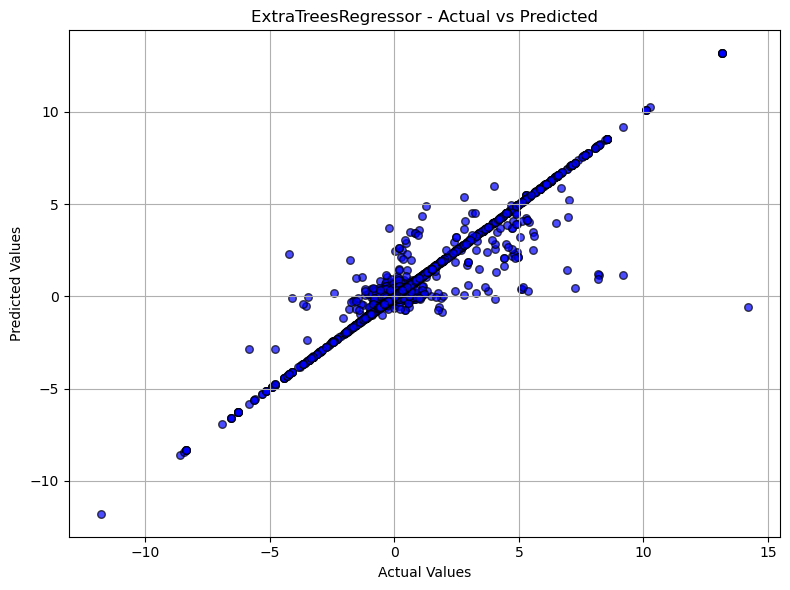

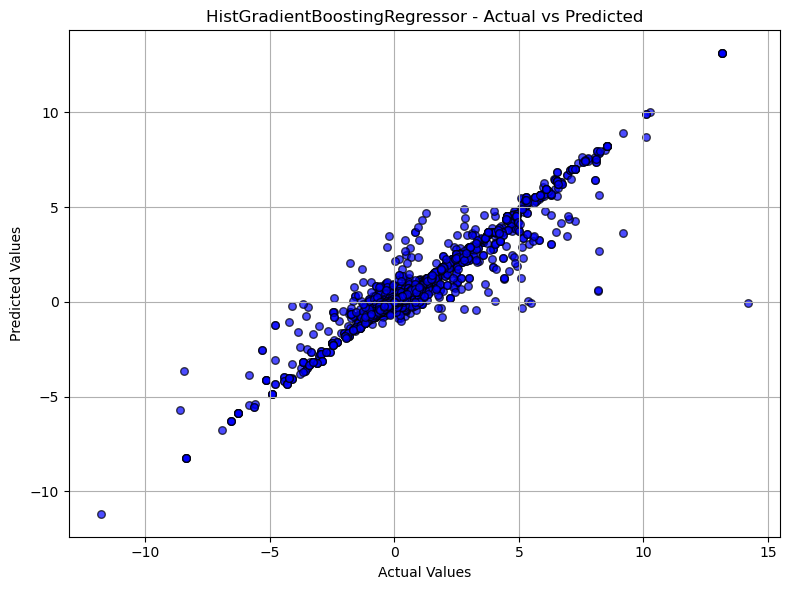

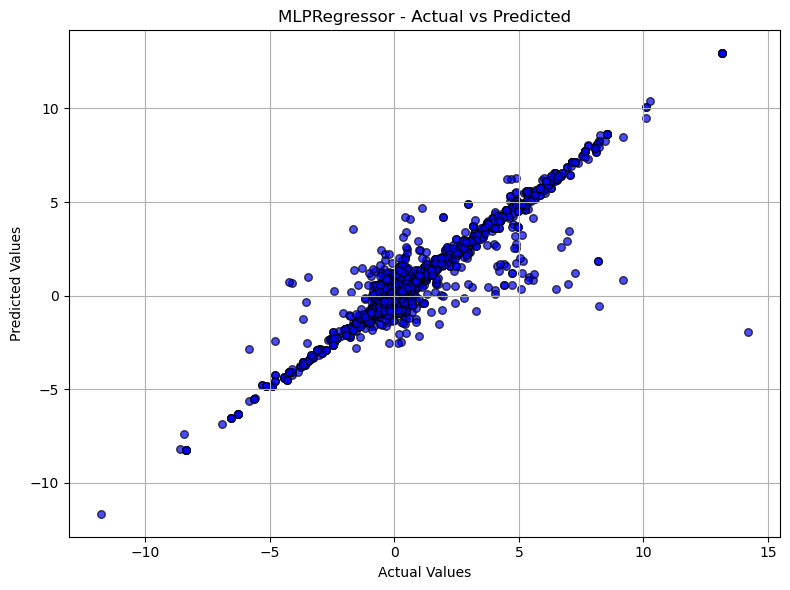

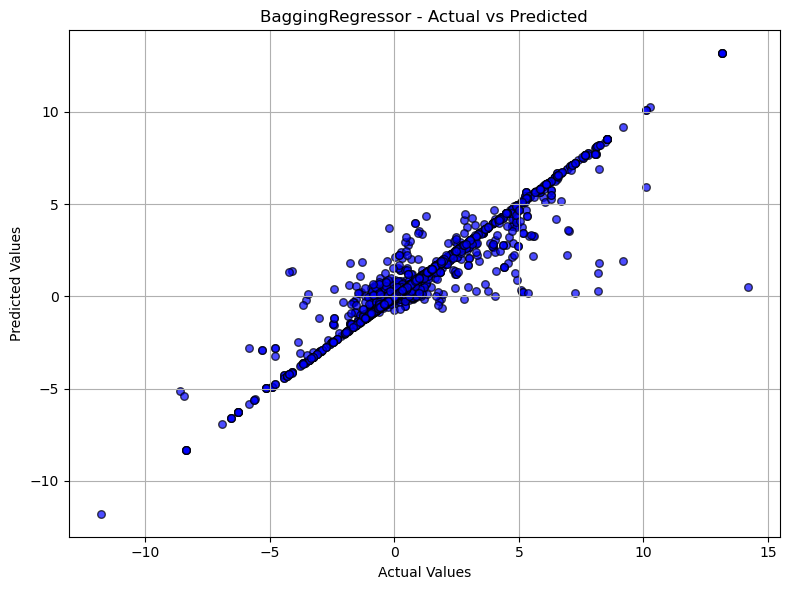

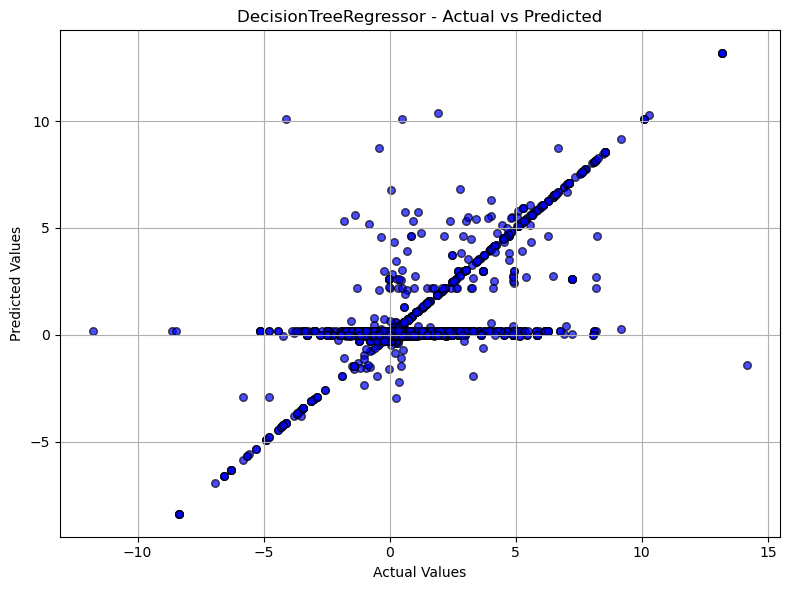

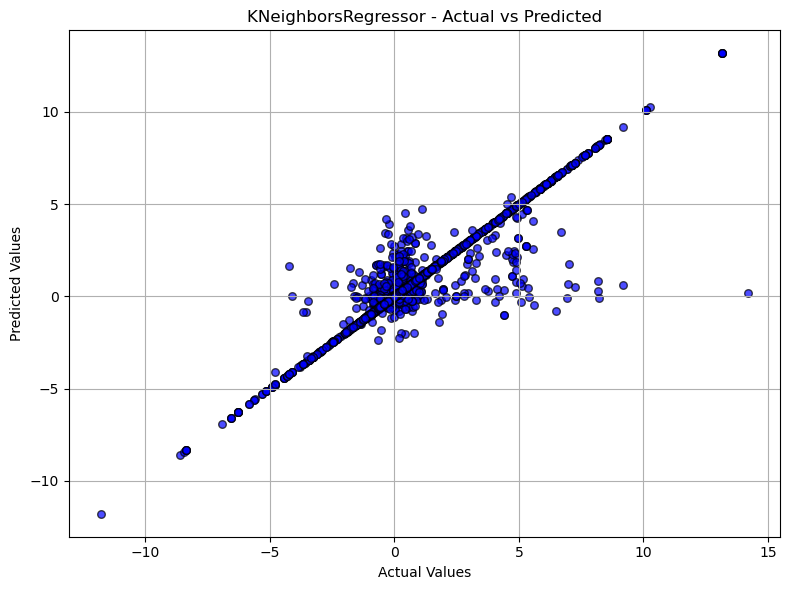

In [2]:
import matplotlib.pyplot as plt

# Loop over each model to create separate Actual vs Predicted plots
for name, model in models.items():
    # Fit the model and make predictions
    if name in ["MLPRegressor", "KNeighborsRegressor"]:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    
    # Plot Actual vs Predicted
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, color='blue', edgecolors='black', alpha=0.7, s=30)
    plt.title(f'{name} - Actual vs Predicted')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Feature Importance

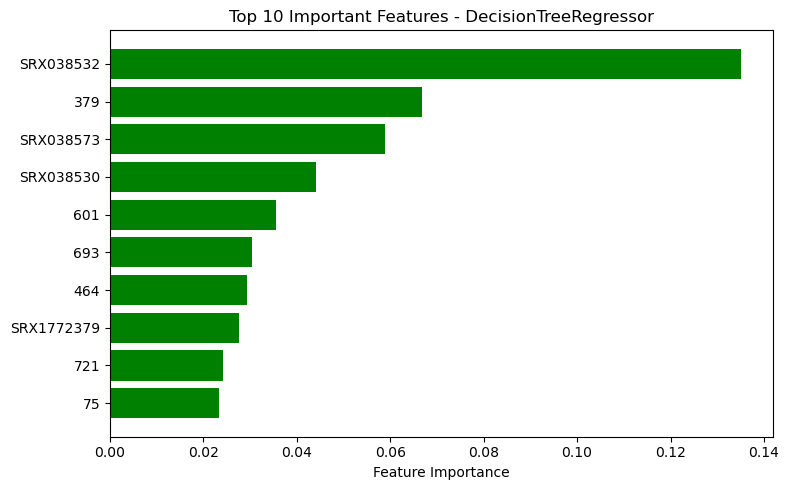

In [3]:
# Fit the DecisionTreeRegressor
model = DecisionTreeRegressor(max_depth=20, min_samples_split=2, random_state=42)
model.fit(X_train, y_train)

# Get feature importances
feature_importances = model.feature_importances_

# Create a DataFrame with feature names and their corresponding importance
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

# Sort the DataFrame by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Select the top 10 most important features
top_10_features = importance_df.head(10)

# Plotting
plt.figure(figsize=(8, 5))
plt.barh(top_10_features['Feature'], top_10_features['Importance'], color='green')
plt.xlabel('Feature Importance')
plt.title('Top 10 Important Features - DecisionTreeRegressor')
plt.gca().invert_yaxis()  
plt.tight_layout()
plt.show()
